# galaxy - Engineered features
* Ryan Kazmerik & Nakisa Rad
* Jan 24, 2022

## Hypothesis
The goal of this notebook is to compare the results of the model with the model using standard StellarAlgo features with the engineered retention model features.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 6 # galaxy
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMLS].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(25439, 54)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25439 entries, 0 to 25438
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            25439 non-null  int64  
 1   dimCustomerMasterId     25439 non-null  int64  
 2   customerNumber          25439 non-null  object 
 3   year                    25439 non-null  int64  
 4   productGrouping         25439 non-null  object 
 5   totalSpent              25439 non-null  float64
 6   recentDate              25439 non-null  object 
 7   attendancePercent       25439 non-null  float64
 8   renewedBeforeDays       25421 non-null  float64
 9   isBuyer                 25439 non-null  object 
 10  source_tenure           25421 non-null  float64
 11  tenure                  25421 non-null  float64
 12  distToVenue             25439 non-null  float64
 13  totalGames              25439 non-null  int64  
 14  recency                 25439 non-null

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = ["year",
            "isNextYear_Buyer",
            "productGrouping",
            "dimCustomerMasterId",
           "totalSpent",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "recency",
        "totalGames",
        "missed_games_1",
        "missed_games_2",
        "click_link",
        "open_email",
        "send_email",
        "openToSendRatio",
        "clickToSendRatio"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (14111, 17)
Unseen Data For Predictions: (2490, 17)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
       "totalSpent",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "recency",
        "totalGames",
        "missed_games_1",
        "missed_games_2",
        "click_link",
        "open_email",
        "send_email",
        "openToSendRatio",
        "clickToSendRatio"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7931,0.8588,0.8486,0.8050,0.8262,0.5712,0.5726,0.6110
lr,Logistic Regression,0.7625,0.8237,0.8404,0.7706,0.8040,0.5041,0.5072,0.5140


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7883,0.8546,0.8403,0.8033,0.8214,0.5620,0.5628
1,0.7867,0.8592,0.8547,0.7931,0.8227,0.5559,0.5583
2,0.8025,0.8614,0.8647,0.8078,0.8353,0.5894,0.5915
3,0.7967,0.8550,0.8432,0.8128,0.8277,0.5799,0.5805
4,0.8007,0.8674,0.8662,0.8048,0.8344,0.5850,0.5875
5,0.8057,0.8764,0.8705,0.8088,0.8385,0.5954,0.5979
6,0.7948,0.8575,0.8345,0.8158,0.8250,0.5771,0.5773
7,0.7907,0.8530,0.8345,0.8101,0.8221,0.5679,0.5683
8,0.7723,0.8412,0.8259,0.7906,0.8079,0.5288,0.5295
9,0.7932,0.8621,0.8518,0.8033,0.8268,0.5706,0.5721


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(4694, 54)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
20745,6,450019493,98920122,2021,Full Season,461.5,2021-11-07,0.750000,290.0,TRUE,...,Completed High School,0,0.0,1,24,0,0,0,0.7535,0.2465
20746,6,450019565,9228651,2021,Full Season,585.0,2021-11-07,1.083333,290.0,TRUE,...,Completed High School,0,0.0,1,24,0,1,1,0.0380,0.9620
20747,6,450019566,20769777,2021,Full Season,3081.0,2021-11-07,1.000000,290.0,TRUE,...,Completed High School,0,0.0,1,24,0,1,1,0.0706,0.9294
20748,6,450021495,8034390,2021,Full Season,702.0,2021-11-07,1.000000,305.0,TRUE,...,Completed College,0,0.0,1,24,0,1,1,0.2888,0.7112
20749,6,450021577,10233647,2021,Partial Plan,552.0,2021-11-07,1.200000,302.0,TRUE,...,Completed High School,0,0.0,1,24,0,1,1,0.1281,0.8719


In [11]:
new_predictions["Label"].value_counts()

0    2485
1    2209
Name: Label, dtype: int64

In [12]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    1795
(0.8, 1.0]       1236
(0.6, 0.8]        711
(0.4, 0.6]        510
(0.2, 0.4]        442
Name: Score_1, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

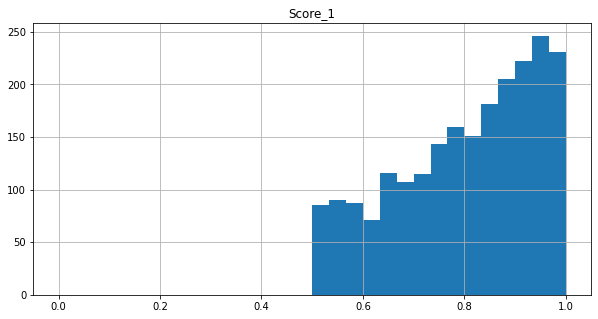

In [13]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

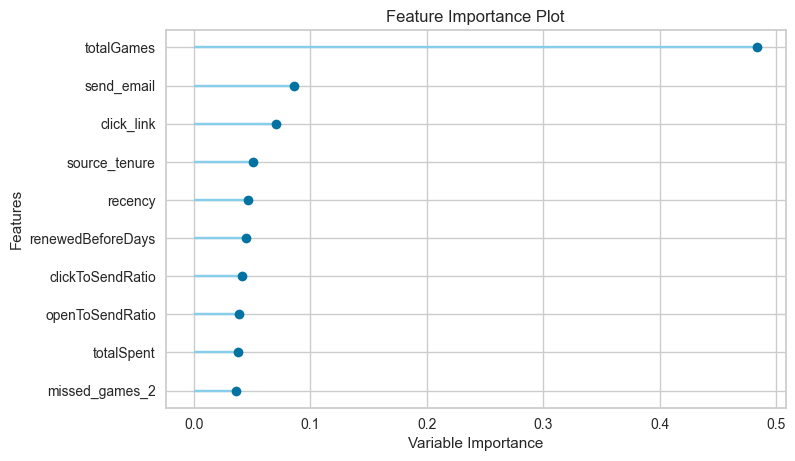

In [14]:
plot_model(best_model, plot='feature')

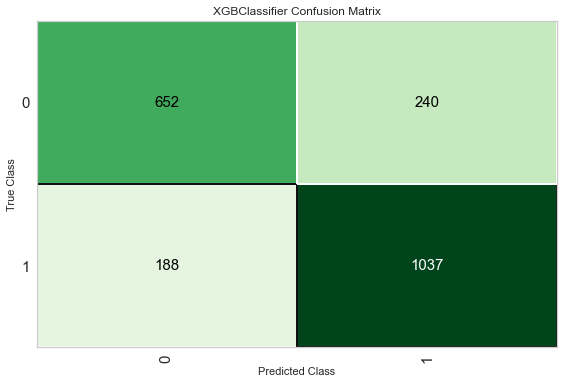

In [15]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above


## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?